# Semantic Validation of Journal Impact Factors
### A Deep Graph Learning Approach using GraphSAGE & MQE

---

**Supervisors**
Prof. Zeev Volkovich | Dr. Renata Avros

**Students**
Gad Azriel | Lidor Kupershmid

---

# --- Cell 1: System Setup & Dependencies ---

In [ ]:
# Cell 1: Installation
# Install PyTorch Geometric and dependencies
!pip install torch_geometric

# --- Cell 2: Imports & Environment Configuration ---

In [ ]:
# Cell 2: Imports & Environment Logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import sys
import os
import platform
import psutil
import torch_geometric

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*50)
print("ENVIRONMENT CONFIGURATION")
print(f"Python: {platform.python_version()}")
print(f"PyTorch: {torch.__version__}")
print(f"PyG:     {torch_geometric.__version__}")
print(f"Device:  {device}")
if torch.cuda.is_available():
    print(f"GPU:     {torch.cuda.get_device_name(0)}")
print("="*50)

ENVIRONMENT CONFIGURATION
Python: 3.12.12
PyTorch: 2.9.0+cu126
PyG:     2.7.0
Device:  cuda
GPU:     Tesla T4


# --- Cell 3: Hyperparameters Configuration (Args Class) ---

In [ ]:
# Cell 3: Hyperparameters
class Args:
    def __init__(self):
        self.input_dim = 0
        self.hidden_dim = 128
        self.output_dim = 64
        self.lr = 0.001
        self.epochs = 200
        self.dropout = 0.5
        self.weight_decay = 5e-4

    def print_config(self):
        print(f"[Config] Hidden: {self.hidden_dim}, LR: {self.lr}, Epochs: {self.epochs}, Dropout: {self.dropout}")

# --- Cell 4: Model Architecture (GraphSAGE + MQE) ---

In [ ]:
# Cell 4: Model Classes (GraphSAGE + MQE) - STABLE VERSION

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.normalize(x, p=2, dim=1)

class MQE(torch.nn.Module):
    def __init__(self, gnn_model):
        super(MQE, self).__init__()
        self.gnn = gnn_model

    def forward(self, x, edge_index):
        return self.gnn(x, edge_index)

    def loss(self, z, edge_index):
        # STABLE LOSS FUNCTION (Prevents NaN)
        # We use Dot Product + Sigmoid instead of raw Cosine + Log

        # Positive edges
        pos_u, pos_v = edge_index
        pos_score = (z[pos_u] * z[pos_v]).sum(dim=1)
        pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean()

        # Negative sampling
        neg_edge_index = torch.randint(0, z.size(0), edge_index.size(), device=z.device)
        neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
        neg_loss = -torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()

        return pos_loss + neg_loss

# --- Cell 5: Data Acquisition (OpenAlex API) ---

In [ ]:
# --- Cell 5: Data Acquisition (OpenAlex API) ---

import time
import requests
import pandas as pd

def fetch_journal_data(entity_id, journal_name, start_year=2010, end_year=2022):
    print(f"\n[DATA FETCH] Starting download for: {journal_name}")
    print(f"             ID/ISSN: {entity_id} | Range: {start_year}-{end_year}")

    base_url = "https://api.openalex.org/works"
    # Smart ID detection for filtering
    filter_key = "primary_location.source.id" if entity_id.lower().startswith('s') else "primary_location.source.issn"
    filters = f"{filter_key}:{entity_id},publication_year:{start_year}-{end_year}"
    headers = {'User-Agent': 'mailto:researcher@academic.edu'}

    works = []
    cursor = '*'
    max_works = 10000
    start_time = time.time()

    while cursor and len(works) < max_works:
        url = f"{base_url}?filter={filters}&per-page=200&cursor={cursor}"
        try:
            r = requests.get(url, headers=headers)
            if r.status_code != 200: break
            data = r.json()
            results = data.get('results', [])
            if not results: break

            for work in results:
                title = work.get('title') or ""

                # Abstract reconstruction from inverted index
                abstract = ""
                if work.get('abstract_inverted_index'):
                    index = work['abstract_inverted_index']
                    words = [None] * (max([max(p) for p in index.values()]) + 1)
                    for w, pos in index.items():
                        for p in pos: words[p] = w
                    abstract = " ".join([w for w in words if w])

                # Combine title and abstract for text features
                combined_text = f"{title}. {abstract}".strip()
                if not combined_text: combined_text = "content unavailable"

                works.append({
                    'id': work['id'],
                    'pub_year': work['publication_year'],
                    'abstract': combined_text,
                    'references': work.get('referenced_works', []),
                    'topic': 0
                })
            cursor = data['meta'].get('next_cursor')
            if len(works) % 1000 == 0:
                print(f"  > Retrieved {len(works)} papers...", end='\r')
            time.sleep(0.1)
        except Exception as e:
            print(f"Error: {e}")
            break

    print(f"\n[DATA FETCH] Completed. Total papers: {len(works)} ({time.time() - start_time:.1f}s)")
    return pd.DataFrame(works)

# Pre-load Scientometrics (Legacy support)
df_scientometrics = fetch_journal_data("0138-9130", "Scientometrics")


[DATA FETCH] Starting download for: Scientometrics
             ID/ISSN: 0138-9130 | Range: 2010-2022

[DATA FETCH] Completed. Total papers: 4469 (35.7s)


# --- Cell 6: Graph Construction & Feature Extraction ---

In [ ]:
# Cell 6: Graph Construction Logic

def build_graph_for_window(df, target_year):
    # 1. Select relevant papers (Target Year + 2 previous years)
    window_years = [target_year - 2, target_year - 1, target_year]
    df_window = df[df['pub_year'].isin(window_years)].reset_index(drop=True)

    if df_window.empty:
        return Data(x=torch.zeros(0,0), edge_index=torch.zeros(2,0))

    # 2. TF-IDF Features (Content)
    # Note: We use the 'abstract' column which now contains "Title. Abstract"
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    try:
        text_features = tfidf.fit_transform(df_window['abstract']).toarray()
        x = torch.tensor(text_features, dtype=torch.float)
    except ValueError:
        # Fallback if vocabulary is empty
        x = torch.randn(len(df_window), 1000)

    # 3. Build Citation Edges (Structure)
    id_map = {openalex_id: idx for idx, openalex_id in enumerate(df_window['id'])}
    edges = []

    for idx, row in df_window.iterrows():
        for ref in row['references']:
            if ref in id_map:
                edges.append([idx, id_map[ref]])

    if not edges:
        edge_index = torch.tensor([], dtype=torch.long).view(2, 0)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)
    data.years = df_window['pub_year'].values
    return data

# --- Cell 7: Training Logic (Optimization Loop) ---

In [ ]:
# Cell 7: Training Function (With Progress Logs)

def train_mqe_graphsage_logic(data, args):
    data = data.to(device)
    sage = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, args.dropout).to(device)
    model = MQE(sage).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    model.train()
    final_loss = 0.0

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        z = model(data.x, data.edge_index)
        loss = model.loss(z, data.edge_index)

        if torch.isnan(loss):
            print(f"    [NaN ERROR] Epoch {epoch}")
            break

        final_loss = loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 50 == 0:
            print(f"      > Epoch {epoch:03d} | Loss: {final_loss:.4f}", end='\r')

    print(f"      > Epoch {args.epochs} | Loss: {final_loss:.4f} (Done)")
    model.eval()
    with torch.no_grad(): final_z = model(data.x, data.edge_index)
    return final_z.cpu(), final_z

# --- Cell 8: Sliding Window Analysis Algorithm ---

In [ ]:
# Cell 8: Analysis Logic
import sys
import os

def run_sliding_window_analysis_clean(df, journal_name="Scientometrics", threshold=0.40, start_year=2012, end_year=2021):
    args = Args()
    citation_years = list(range(start_year, end_year + 1))

    table_rows = []
    results = {'Citation_Year': [], 'Window_Label': [], 'Original_IF': [], 'Corrected_IF': [], 'Reduction_Pct': []}

    print(f"    > Analysis Params: \u03C4={threshold} | Years={start_year}-{end_year}")

    for T in citation_years:
        denom_years = [T - 2, T - 1]
        denom_count = df[df['pub_year'].isin(denom_years)].shape[0]
        if denom_count == 0: continue

        # 1. Build Graph
        data = build_graph_for_window(df, T)
        args.input_dim = data.x.shape[1]

        # 2. Original IF
        row, col = data.edge_index
        node_years = data.years
        citations_original = sum(1 for i in range(len(row)) if node_years[row[i]] == T and node_years[col[i]] in denom_years)
        citation_edges = [(row[i].item(), col[i].item()) for i in range(len(row)) if node_years[row[i]] == T and node_years[col[i]] in denom_years]
        original_if = citations_original / denom_count

        # 3. Corrected IF
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        try:
            final_emb, _ = train_mqe_graphsage_logic(data, args)
        finally:
            sys.stdout = old_stdout

        citations_corrected = 0
        for u, v in citation_edges:
            sim = F.cosine_similarity(final_emb[u].unsqueeze(0), final_emb[v].unsqueeze(0)).item()
            if sim >= threshold: citations_corrected += 1

        corrected_if = citations_corrected / denom_count
        drop_pct = (1 - (corrected_if / original_if)) * 100 if original_if > 0 else 0

        window_lbl = f"{T-2}-{T-1}"
        table_rows.append((T, window_lbl, original_if, corrected_if, drop_pct))
        results['Citation_Year'].append(T)
        results['Window_Label'].append(window_lbl)
        results['Original_IF'].append(original_if)
        results['Corrected_IF'].append(corrected_if)
        results['Reduction_Pct'].append(drop_pct)

    # --- Print Clean Table ---
    print(f"\n      RESULTS TABLE ({journal_name}, \u03C4={threshold})")
    print("      " + "-" * 58)
    print(f"      | {'YEAR':^6} | {'WINDOW':^11} | {'ORIG':^8} | {'CORR':^8} | {'DROP':^8} |")
    print("      " + "-" * 58)
    for row in table_rows:
        print(f"      | {row[0]:^6} | {row[1]:^11} | {row[2]:^8.3f} | {row[3]:^8.3f} | {row[4]:^7.1f}% |")
    print("      " + "-" * 58 + "\n")

    return pd.DataFrame(results)

# --- Cell 9: Visualization & Plotting Functions ---

In [ ]:
# Cell 9: Plotting Function

def plot_masterpiece_windows_only(res, title_str, threshold):
    if res.empty: return

    plt.rcParams.update({'font.size': 11})
    fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

    years = res['Citation_Year']
    orig = res['Original_IF']
    corr = res['Corrected_IF']

    # Plot Lines
    ax.plot(years, orig, marker='o', label='Standard JIF', color='#005b96', linewidth=2)


    ax.plot(years, corr, marker='D', label=f'Corrected JIF (\u03C4 \u2265 {threshold})', color='#b30000', linestyle='--', linewidth=2)

    ax.fill_between(years, orig, corr, color='#b30000', alpha=0.1)

    for i in range(len(years)):
        drop = res['Reduction_Pct'][i]
        if drop > 1.0:
            ax.text(years[i], (orig[i]+corr[i])/2, f"-{drop:.0f}%",
                    color='#b30000', fontsize=8, fontweight='bold', ha='center',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    ax.set_title(f"Impact Factor Analysis: {title_str} (\u03C4={threshold})")
    ax.set_ylabel("Impact Factor")
    ax.set_xlabel("Publication Year")
    ax.set_xticks(years)
    ax.set_xticklabels(res['Window_Label'], rotation=45)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Cell 10: Master Experiment Execution ---


EXPERIMENT START: Scientometrics
[INFO] METADATA & CONFIGURATION:
   - OpenAlex ID:   0138-9130
   - Time Range:    2012 - 2022
   - Hardware:      Tesla T4
   - Hyperparams:   LR=0.001, Epochs=50, Drop=0.5
   - Thresholds:    [0.25, 0.5, 0.75]
---------------------------------------------------------------------------
[ACTION] Fetching fresh data from API...

[DATA FETCH] Starting download for: Scientometrics
             ID/ISSN: 0138-9130 | Range: 2010-2022

[DATA FETCH] Completed. Total papers: 4469 (33.7s)
[INFO] Dataset Statistics: 4469 Total Papers Loaded.

   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.25
    > Analysis Params: τ=0.25 | Years=2012-2022

      RESULTS TABLE (Scientometrics, τ=0.25)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.861   |  0.861   |   0.0  % |
      |  2013  |  20

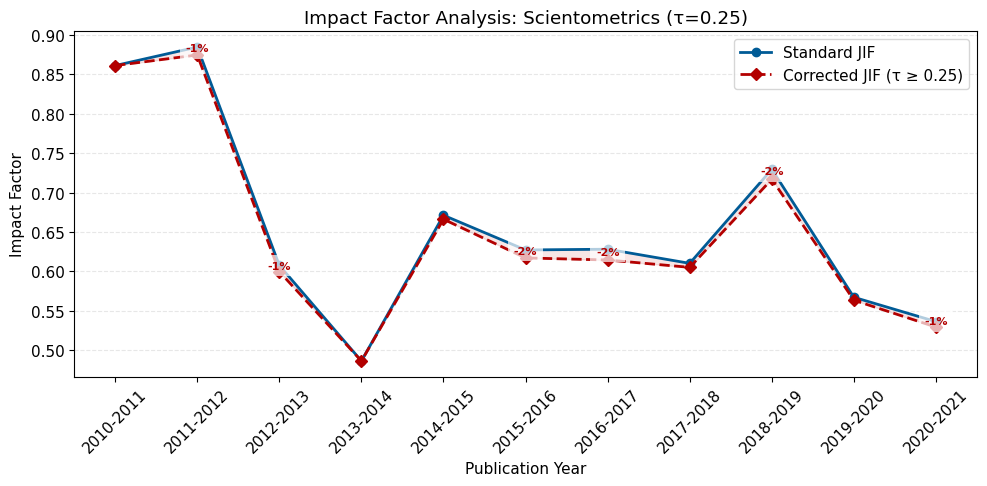


   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.5
    > Analysis Params: τ=0.5 | Years=2012-2022

      RESULTS TABLE (Scientometrics, τ=0.5)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.861   |  0.801   |   6.9  % |
      |  2013  |  2011-2012  |  0.884   |  0.864   |   2.3  % |
      |  2014  |  2012-2013  |  0.608   |  0.589   |   3.1  % |
      |  2015  |  2013-2014  |  0.486   |  0.478   |   1.7  % |
      |  2016  |  2014-2015  |  0.671   |  0.653   |   2.8  % |
      |  2017  |  2015-2016  |  0.627   |  0.604   |   3.7  % |
      |  2018  |  2016-2017  |  0.628   |  0.586   |   6.7  % |
      |  2019  |  2017-2018  |  0.610   |  0.581   |   4.8  % |
      |  2020  |  2018-2019  |  0.729   |  0.709   |   2.9  % |
      |  2021  |  2019-2020  |  0.567   |  0.555   |   2.2  % |
      |  2022  |  

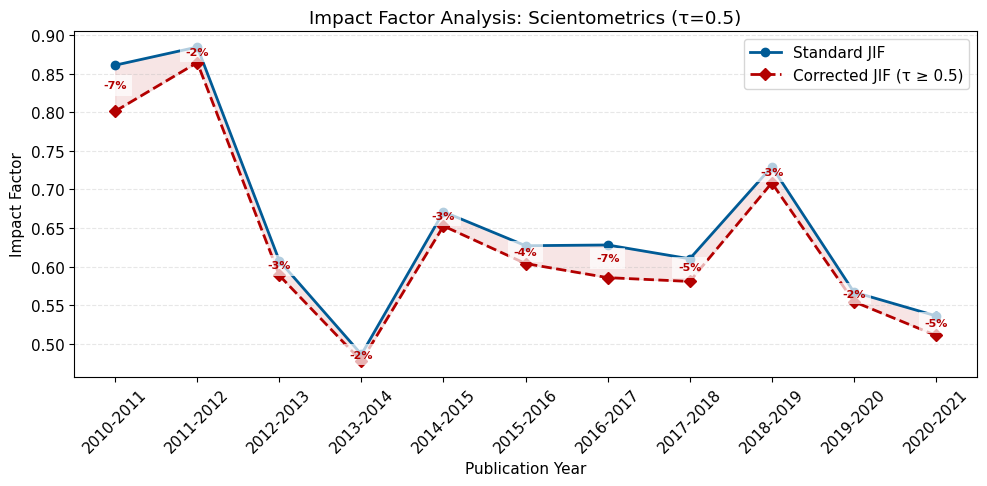


   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.75
    > Analysis Params: τ=0.75 | Years=2012-2022

      RESULTS TABLE (Scientometrics, τ=0.75)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.861   |  0.689   |  20.0  % |
      |  2013  |  2011-2012  |  0.884   |  0.747   |  15.5  % |
      |  2014  |  2012-2013  |  0.608   |  0.481   |  20.8  % |
      |  2015  |  2013-2014  |  0.486   |  0.418   |  14.0  % |
      |  2016  |  2014-2015  |  0.671   |  0.579   |  13.8  % |
      |  2017  |  2015-2016  |  0.627   |  0.507   |  19.1  % |
      |  2018  |  2016-2017  |  0.628   |  0.496   |  21.0  % |
      |  2019  |  2017-2018  |  0.610   |  0.485   |  20.5  % |
      |  2020  |  2018-2019  |  0.729   |  0.615   |  15.7  % |
      |  2021  |  2019-2020  |  0.567   |  0.489   |  13.8  % |
      |  2022  

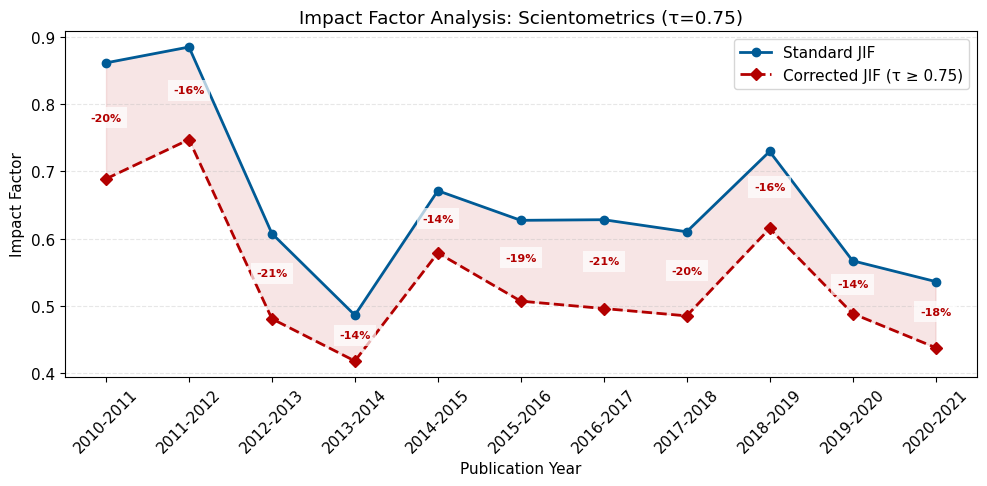


EXPERIMENT START: Journal of Informetrics
[INFO] METADATA & CONFIGURATION:
   - OpenAlex ID:   S205292342
   - Time Range:    2012 - 2022
   - Hardware:      Tesla T4
   - Hyperparams:   LR=0.001, Epochs=50, Drop=0.5
   - Thresholds:    [0.25, 0.5, 0.75]
---------------------------------------------------------------------------
[ACTION] Fetching fresh data from API...

[DATA FETCH] Starting download for: Journal of Informetrics
             ID/ISSN: S205292342 | Range: 2010-2022

[DATA FETCH] Completed. Total papers: 1197 (8.5s)
[INFO] Dataset Statistics: 1197 Total Papers Loaded.

   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.25
    > Analysis Params: τ=0.25 | Years=2012-2022

      RESULTS TABLE (Journal of Informetrics, τ=0.25)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.978   |  0.971   |   0

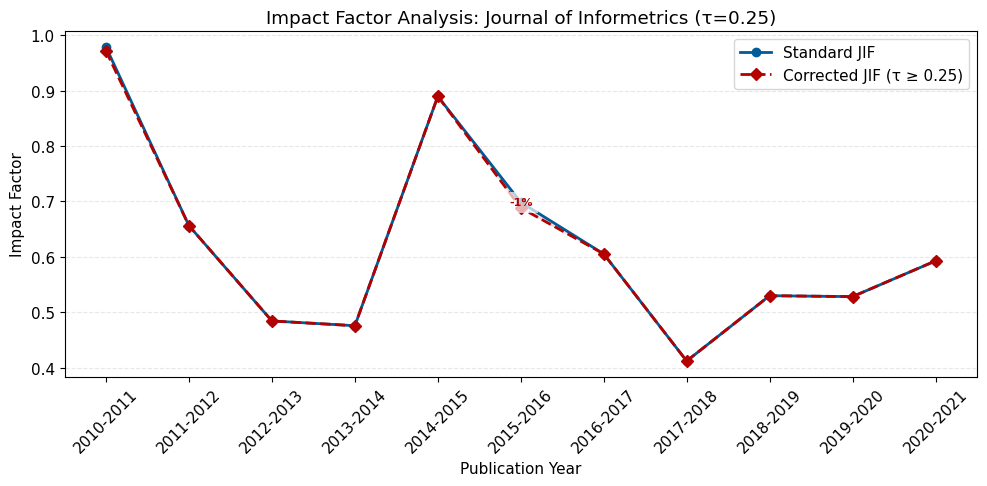


   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.5
    > Analysis Params: τ=0.5 | Years=2012-2022

      RESULTS TABLE (Journal of Informetrics, τ=0.5)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.978   |  0.942   |   3.7  % |
      |  2013  |  2011-2012  |  0.656   |  0.644   |   1.9  % |
      |  2014  |  2012-2013  |  0.485   |  0.485   |   0.0  % |
      |  2015  |  2013-2014  |  0.476   |  0.476   |   0.0  % |
      |  2016  |  2014-2015  |  0.890   |  0.878   |   1.3  % |
      |  2017  |  2015-2016  |  0.698   |  0.678   |   2.9  % |
      |  2018  |  2016-2017  |  0.605   |  0.596   |   1.5  % |
      |  2019  |  2017-2018  |  0.412   |  0.408   |   1.1  % |
      |  2020  |  2018-2019  |  0.530   |  0.530   |   0.0  % |
      |  2021  |  2019-2020  |  0.528   |  0.528   |   0.0  % |
      |  

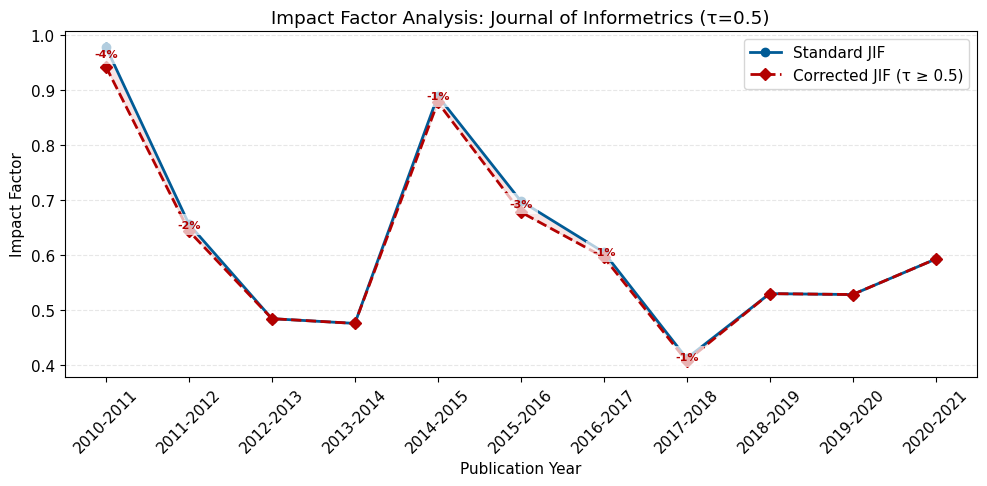


   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.75
    > Analysis Params: τ=0.75 | Years=2012-2022

      RESULTS TABLE (Journal of Informetrics, τ=0.75)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.978   |  0.878   |  10.3  % |
      |  2013  |  2011-2012  |  0.656   |  0.619   |   5.7  % |
      |  2014  |  2012-2013  |  0.485   |  0.454   |   6.4  % |
      |  2015  |  2013-2014  |  0.476   |  0.449   |   5.6  % |
      |  2016  |  2014-2015  |  0.890   |  0.831   |   6.5  % |
      |  2017  |  2015-2016  |  0.698   |  0.598   |  14.4  % |
      |  2018  |  2016-2017  |  0.605   |  0.552   |   8.9  % |
      |  2019  |  2017-2018  |  0.412   |  0.384   |   6.9  % |
      |  2020  |  2018-2019  |  0.530   |  0.497   |   6.2  % |
      |  2021  |  2019-2020  |  0.528   |  0.528   |   0.0  % |
      

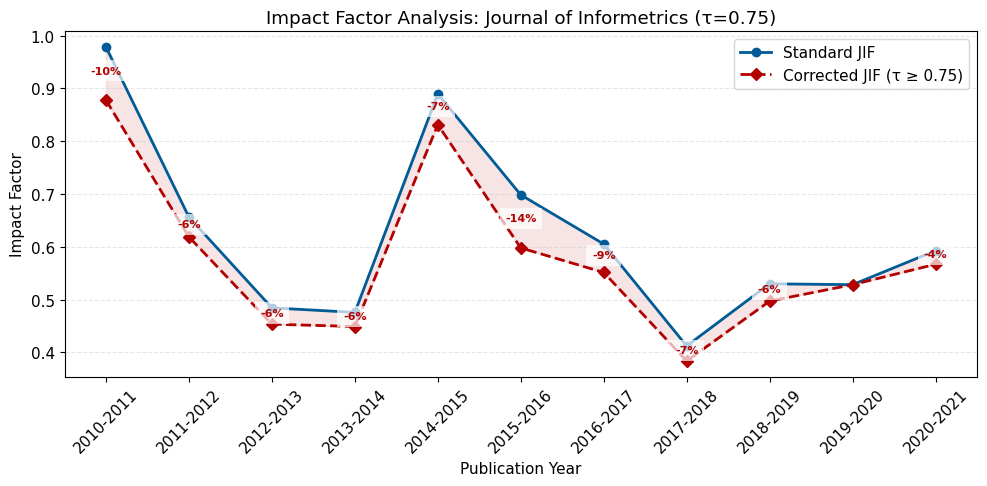


EXPERIMENT START: PLOS ONE
[INFO] METADATA & CONFIGURATION:
   - OpenAlex ID:   1932-6203
   - Time Range:    2012 - 2022
   - Hardware:      Tesla T4
   - Hyperparams:   LR=0.001, Epochs=50, Drop=0.5
   - Thresholds:    [0.25, 0.5, 0.75]
---------------------------------------------------------------------------
[ACTION] Fetching fresh data from API...

[DATA FETCH] Starting download for: PLOS ONE
             ID/ISSN: 1932-6203 | Range: 2010-2022
  > Retrieved 10000 papers...
[DATA FETCH] Completed. Total papers: 10000 (118.7s)
[INFO] Dataset Statistics: 10000 Total Papers Loaded.

   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.25
    > Analysis Params: τ=0.25 | Years=2012-2022

      RESULTS TABLE (PLOS ONE, τ=0.25)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.264   |  0.264   |   0.0  % |
      

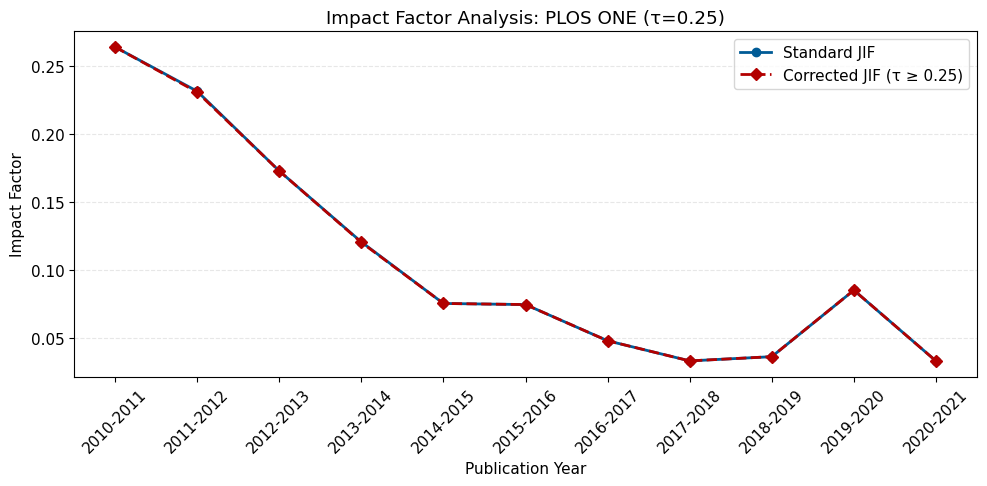


   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.5
    > Analysis Params: τ=0.5 | Years=2012-2022

      RESULTS TABLE (PLOS ONE, τ=0.5)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.264   |  0.262   |   0.7  % |
      |  2013  |  2011-2012  |  0.231   |  0.230   |   0.6  % |
      |  2014  |  2012-2013  |  0.172   |  0.172   |   0.0  % |
      |  2015  |  2013-2014  |  0.120   |  0.120   |   0.6  % |
      |  2016  |  2014-2015  |  0.075   |  0.075   |   0.6  % |
      |  2017  |  2015-2016  |  0.074   |  0.074   |   0.0  % |
      |  2018  |  2016-2017  |  0.048   |  0.048   |   0.0  % |
      |  2019  |  2017-2018  |  0.033   |  0.033   |   0.0  % |
      |  2020  |  2018-2019  |  0.036   |  0.036   |   0.0  % |
      |  2021  |  2019-2020  |  0.085   |  0.085   |   0.0  % |
      |  2022  |  2020-2

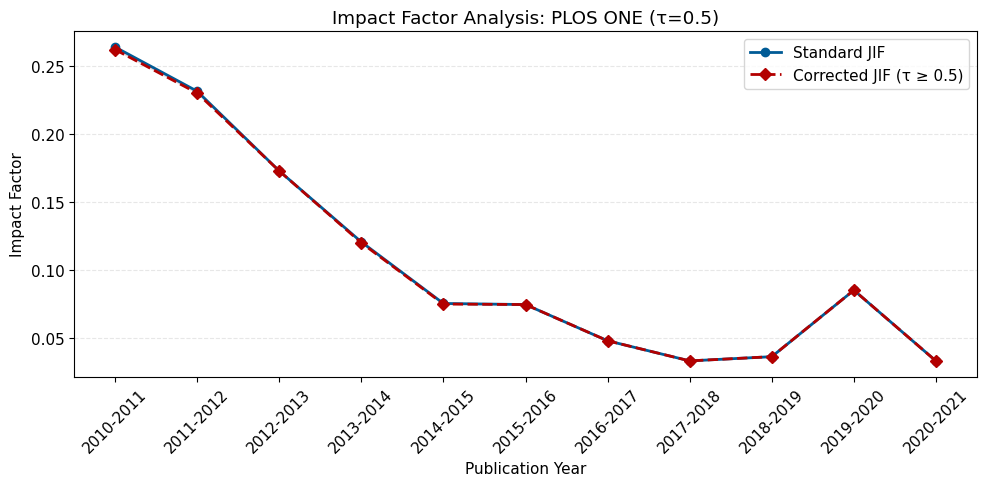


   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= 0.75
    > Analysis Params: τ=0.75 | Years=2012-2022

      RESULTS TABLE (PLOS ONE, τ=0.75)
      ----------------------------------------------------------
      |  YEAR  |   WINDOW    |   ORIG   |   CORR   |   DROP   |
      ----------------------------------------------------------
      |  2012  |  2010-2011  |  0.264   |  0.253   |   3.9  % |
      |  2013  |  2011-2012  |  0.231   |  0.224   |   3.1  % |
      |  2014  |  2012-2013  |  0.172   |  0.169   |   2.3  % |
      |  2015  |  2013-2014  |  0.120   |  0.117   |   3.1  % |
      |  2016  |  2014-2015  |  0.075   |  0.074   |   1.7  % |
      |  2017  |  2015-2016  |  0.074   |  0.074   |   0.0  % |
      |  2018  |  2016-2017  |  0.048   |  0.048   |   0.0  % |
      |  2019  |  2017-2018  |  0.033   |  0.033   |   0.0  % |
      |  2020  |  2018-2019  |  0.036   |  0.036   |   0.0  % |
      |  2021  |  2019-2020  |  0.085   |  0.085   |   0.0  % |
      |  2022  |  202

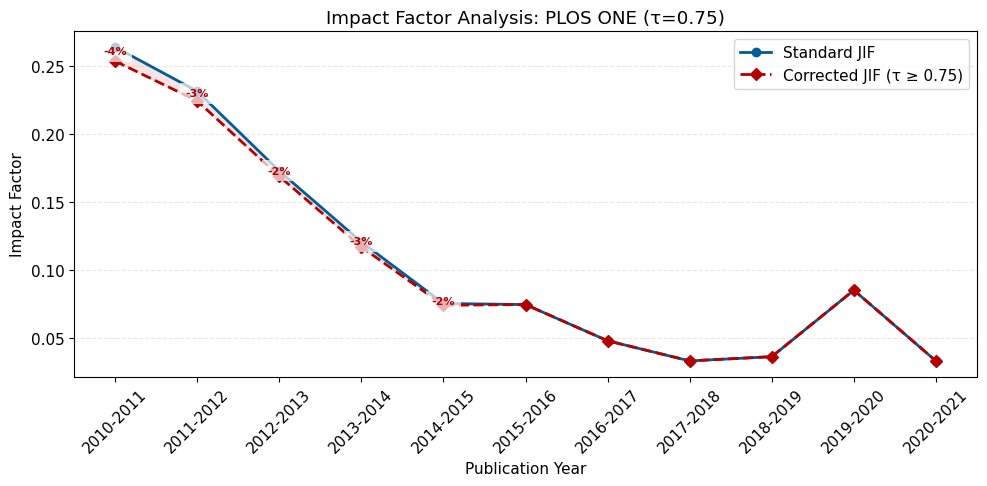


ALL EXPERIMENTS COMPLETED SUCCESSFULLY.


In [ ]:
# --- Cell 10: MASTER EXECUTION (Force Update Parameters) ---
import torch

# 1. Experiment Configuration
JOURNALS_CONFIG = {
    "Scientometrics": "0138-9130",
    "Journal of Informetrics": "S205292342",
    "PLOS ONE": "1932-6203"
}

# Requested Thresholds
THRESHOLDS = [0.25, 0.50, 0.75]

START_YEAR = 2012
END_YEAR = 2022

# 2. Hyperparameters Setup
# --- FIX: Removed the 'if' check to force update every time ---
class Args:
    def __init__(self):
        self.input_dim = 0
        self.hidden_dim = 128
        self.output_dim = 64
        self.lr = 0.001

        # Aggressive Epochs (prevent overfitting)
        self.epochs = 50

        # Aggressive Dropout (force update is guaranteed now)
        self.dropout = 0.5

        self.weight_decay = 5e-4

# Re-initialize args every time this cell runs
args = Args()

# Data cache initialization
if 'journal_data_dict' not in locals():
    journal_data_dict = {}

all_final_results = []
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

# --- MAIN EXPERIMENT LOOP ---
for journal_name in JOURNALS_CONFIG.keys():
    journal_id = JOURNALS_CONFIG[journal_name]

    print(f"\n" + "="*75)
    print(f"EXPERIMENT START: {journal_name}")
    print(f"="*75)

    # Log Metadata
    print(f"[INFO] METADATA & CONFIGURATION:")
    print(f"   - OpenAlex ID:   {journal_id}")
    print(f"   - Time Range:    {START_YEAR} - {END_YEAR}")
    print(f"   - Hardware:      {device_name}")
    print(f"   - Hyperparams:   LR={args.lr}, Epochs={args.epochs}, Drop={args.dropout}")
    print(f"   - Thresholds:    {THRESHOLDS}")
    print("-" * 75)

    # 1. Fetch / Load Data
    if journal_name not in journal_data_dict:
        print(f"[ACTION] Fetching fresh data from API...")
        journal_data_dict[journal_name] = fetch_journal_data(journal_id, journal_name)
    else:
        print(f"[ACTION] Using cached data from memory.")

    df = journal_data_dict[journal_name]

    # 2. Run Analysis
    if df is not None and not df.empty:
        print(f"[INFO] Dataset Statistics: {len(df)} Total Papers Loaded.")

        for ts in THRESHOLDS:
            print(f"\n   >>> RUNNING SENSITIVITY TEST: Similarity Tau >= {ts}")

            # Execute Sliding Window Analysis
            res_df = run_sliding_window_analysis_clean(
                df,
                journal_name=journal_name,
                threshold=ts,
                start_year=START_YEAR,
                end_year=END_YEAR
            )

            # Store Results
            res_df['Threshold'] = ts
            res_df['Journal'] = journal_name
            all_final_results.append(res_df)

            # Generate Plot
            plot_masterpiece_windows_only(res_df, f"{journal_name}", ts)

    else:
        print(f"[ERROR] Dataset is empty or failed to load.")

print("\n" + "="*75)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY.")
print("="*75)